In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import os
import pickle

In [23]:
def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

full_data = load_obj('data')

subject_list = [f for f in os.listdir('./data/head_tracking_data') if 'Subject' in f] # list of all subjects
video_list = [f for f in os.listdir('./data/video_files') if 'mp4' in f] # list of all videos

In [24]:
G = nx.DiGraph()

for subj in subject_list:
    for i in range(len(full_data['Help.mp4'][subj])-1):
        
        # connect previous set of [top left zone, bottom right zone] to current [top left zone, bottom right zone]
        G.add_edge((str(full_data['Help.mp4'][subj].iloc[i]), i), (str(full_data['Help.mp4'][subj].iloc[i+1]), i+1))
        

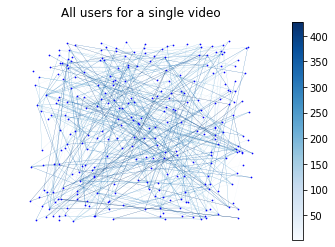

In [25]:
pos = nx.layout.random_layout(G)

node_sizes = 0.5
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [i / M  for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=0.3,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=0.2,
)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
ax.set_axis_off()
plt.title('All users for a single video')
plt.show()
